# Parameters

In [1]:
date = '231007'
bat_id = '32623'

In [2]:
data_path = f'/home/batlab/mnt/server4/users/KevinQi/datasets/GridBat/32622/small_cage/processed/{date}'

In [3]:
%load_ext autoreload
%autoreload 2

import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
#import multical
import json
from config import SniffBat2Dataset
import pandas as pd
import itertools
import decord
from tqdm import tqdm
import numba as nb
import scipy
import warnings
import toml
import pathlib
from parfor import parfor
import config
import json

#from point_cloud_registration import compute_rigid_body_registration, draw_registration_result


from aniposelib.boards import CharucoBoard, Checkerboard
from aniposelib.cameras import Camera, CameraGroup
from aniposelib.utils import load_pose2d_fnames

plt.rcParams["figure.figsize"] = (12,8)

In [4]:
@nb.njit('float64(float64[:,::1])')
def det_4x4(mat):
    a, b, c, d = mat[0,0], mat[0,1], mat[0,2], mat[0,3]
    e, f, g, h = mat[1,0], mat[1,1], mat[1,2], mat[1,3]
    i, j, k, l = mat[2,0], mat[2,1], mat[2,2], mat[2,3]
    m, n, o, p = mat[3,0], mat[3,1], mat[3,2], mat[3,3]
    return a * (f * (k*p - l*o) + g * (l*n - j*p) + h * (j*o - k*n)) + \
            b * (e * (l*o - k*p) + g * (i*p - l*m) + h * (k*m - i*o)) + \
            c * (e * (j*p - l*n) + f * (l*m - i*p) + h * (i*n - j*m)) + \
            d * (e * (k*n - j*o) + f * (i*o - k*m) + g * (j*m - i*n))

@nb.njit('float64[:,::1](float64[:,::1], float64[:,::1])')
def fundamental_3x3_from_projections(p_left_3x4, p_right_3x4):
    f_3x3 = np.empty((3, 3))
    p1, p2 = p_left_3x4, p_right_3x4

    x = np.empty((3, 2, 4), dtype=np.float64)
    x[0, 0, :] = p1[1, :]
    x[0, 1, :] = p1[2, :]
    x[1, 0, :] = p1[2, :]
    x[1, 1, :] = p1[0, :]
    x[2, 0, :] = p1[0, :]
    x[2, 1, :] = p1[1, :]

    y = np.empty((3, 2, 4), dtype=np.float64)
    y[0, 0, :] = p2[1, :]
    y[0, 1, :] = p2[2, :]
    y[1, 0, :] = p2[2, :]
    y[1, 1, :] = p2[0, :]
    y[2, 0, :] = p2[0, :]
    y[2, 1, :] = p2[1, :]

    xy = np.empty((4, 4), dtype=np.float64)

    for i in range(3):
        xy[2:4, :] = y[i, :, :]
        for j in range(3):
            xy[0:2, :] = x[j, :, :]
            f_3x3[i, j] = det_4x4(xy)

    return f_3x3

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,2)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

def drawline(img, line, pts):
    h,w = img.shape
    

def point_line_dist(lines,pts):
    """
    Compute distance from point to line
    
    line : (a,b,c)
        ax + by + c = 0
    pt : (x0,y0)
    """
    a = lines[:,0]
    b = lines[:,1]
    c = lines[:,2].reshape(-1,1)
    x0 = pts[:,0]
    y0 = pts[:,1]
    
    dists = np.abs(np.outer(a,x0) + np.outer(b,y0) + c) / np.sqrt(np.square(a) + np.square(b)).reshape(-1,1)
    return dists

def thresholded_point_line_dist(lines,pts,thresh):
    """
    Compute point line distances between all pts and all lines and apply max dist threshold
    """
    dists = point_line_dist(lines,pts)
    thresh_dists = dists * (dists<thresh).astype(int)
    thresh_dists[thresh_dists == 0] = np.nan
    return dists, thresh_dists

def compute_proj_matrices(calibration, VIEWS):
    proj_matrices = {}
    for view in VIEWS:
        K = np.array(calibration['cameras'][view]['K'])
        key = [k for k in calibration['camera_poses'].keys() if view in k][0]
        t = np.array(calibration['camera_poses'][key]['T']).reshape(-1,1)
        R = np.array(calibration['camera_poses'][key]['R'])
        extrinsic = np.hstack([R,t])
        intrinsic = K
        proj_matrices[view] = np.matmul(intrinsic, extrinsic)
    return proj_matrices

def compute_fundamental(calibration, VIEWS):
    proj_matrices = compute_proj_matrices(calibration, VIEWS)
    
    fundamental_matrices = {}
    for v1 in range(len(VIEWS)):
        fundamental_matrices[VIEWS[v1]] = {}
        for v2 in range(len(VIEWS)):
            #print(VIEWS[v1], VIEWS[v2])
            fundamental_matrices[VIEWS[v1]][VIEWS[v2]] = fundamental_3x3_from_projections(proj_matrices[VIEWS[v1]], 
                                                                                          proj_matrices[VIEWS[v2]])
    return fundamental_matrices

def compute_lines(pts2d,fundamental_matrices, VIEWS):
    """
    Compute all epipolar lines in each camera view from points in all other camera views
    
    Points in camera view 1 should fall on intersection points of corresponding epipolar lines from other views
    """
    lines = {}
    for view1 in VIEWS:
        #print(view1)
        lines[view1] = {}
        for view2 in VIEWS:
            if(view1 != view2):
                # F matrix between view1 and view2
                F = fundamental_matrices[view1][view2]
                pts1 = pts2d[view1]
                pts2 = pts2d[view2]
                if(pts2.size > 0):
                    lines[view1][view2] = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2).astype(np.float32),2,F).reshape(-1,3)
                else: # no detections found in view2
                    lines[view1][view2] = np.array([])
    return lines

def compute_dists(pts2d, lines, fundamental_matrices, VIEWS, threshold):
    """
    Compute distances of each point in view X to epipolar lines from all other views
    Furthermore, apply max distance threshold to only consider point - line pairings that correspond nicely.
    """
    
    adjacency = {}
    dists = {}
    thresh_dists = {}
    for view1 in VIEWS:
        #img = frames[view1][:,:,0]
        pts1 = pts2d[view1]
        adjacency[view1] = {}
        dists[view1] = {}
        thresh_dists[view1] = {}
        for view2 in VIEWS:
            #img2 = frames[view2][:,:,0]
            if(view2 != view1):
                F = fundamental_matrices[view1][view2]
                pts2 = pts2d[view2]
                if(pts2.size > 0 and pts1.size > 0):
                    lines1 = lines[view1][view2]
                    
                    dists[view1][view2], thresh_dists[view1][view2] = thresholded_point_line_dist(lines1,pts1,thresh=threshold)
                    #closest_lines = np.where(np.sum(dist>0,1) == 1)[0]
                else: # If view2 has no detections
                    dists[view1][view2] = np.array([])
                    thresh_dists[view1][view2] = np.array([])
                   
                #closest_pts = np.where(dist[closest_line, :] > 0)[0]
                #adj[closest_lines] = 1

                #adj = np.zeros(dist.shape)

                #adjacency[view1][view2] = 
                #img, img2 = drawlines(img, img2, lines1, pts1, pts2)
                #img = img[:,:,0]
        #imgs[view1] = img
    return dists,thresh_dists

def epipolar_err(ids, dists, VIEWS):
    err = 0
    line_dists = []
    for i in range(len(VIEWS)):
        view1 = VIEWS[i]
        for j in range(len(VIEWS)):
            view2 = VIEWS[j]
            if(i != j):
                dist = dists[view1][view2]
                if(dist.size > 0): # Views with no detections do not contribute to cost
                    #print(dist)
                    v1_idx, v2_idx = (np.array(ids[i]) == np.array(ids[j])[:,np.newaxis]).T.nonzero()
                    #print(v1_idx,v2_idx)

                    line_dists.append(dist[v2_idx,v1_idx])
                        #view_cost.append(dist[v2_idx,v1_idx][0])

                    #err += np.sum(np.square(dist[v2_idx,v1_idx]))
                    #print(err)
        #view_costs.append(np.sum(np.square(np.array(view_cost))))
                    
                
    if(len(line_dists) == 0):
        return np.nan
    
    line_dists = np.concatenate(line_dists)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        err = np.sqrt(np.nanmean(np.square(line_dists)))
    
    return err


def par_epipolar_err(possible_ids, dists, VIEWS):
    @parfor(possible_ids,(dists, VIEWS,),bar = False)
    def epipolar_err(ids, dists, VIEWS):
        err = 0
        line_dists = []
        for i in range(len(VIEWS)):
            view1 = VIEWS[i]
            for j in range(len(VIEWS)):
                view2 = VIEWS[j]
                if(i != j):
                    dist = dists[view1][view2]
                    if(dist.size > 0): # Views with no detections do not contribute to cost
                        #print(dist)
                        v1_idx, v2_idx = (np.array(ids[i]) == np.array(ids[j])[:,np.newaxis]).T.nonzero()
                        #print(v1_idx,v2_idx)
                        try:
                            line_dists.append(dist[v2_idx,v1_idx])
                            #view_cost.append(dist[v2_idx,v1_idx][0])
                        except:
                            pass
                        #err += np.sum(np.square(dist[v2_idx,v1_idx]))
                        #print(err)
            #view_costs.append(np.sum(np.square(np.array(view_cost))))


        if(len(line_dists) == 0):
            return np.nan

        line_dists = np.concatenate(line_dists)
        err = np.sqrt(np.nanmean(np.square(line_dists)))

        return err
    return epipolar_err
                
def count_combinations(arr_of_arr):
    count = 1
    for arr in arr_of_arr:
        count = count * len(arr)
    return count



def nearest_neighbor_correspondence(pts1,pts2):
    """
    Compute correspondence in time via nearest neighbors
    """
    nn_correspondences = []
    for j in range(len(VIEWS)):
        pdist = scipy.spatial.distance.cdist(pts1[j,:,:],pts2[j,:,:])

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            mean_dist = np.nanmean(pdist,axis=0)
        #print(pdist)

        # Detections in subsequent frames are unambiguously close if their distance is much less than the
        # average point-point distance in subsequent frames. Corresponding points should also have small absolute distances.
        is_close = (pdist < mean_dist/3) # @ (pdist < 5)

        # Corresponding points must be ambiguous - There should only be 1 point in subsequent frames that is close.
        is_close = is_close * (np.sum(is_close,0) <= 1)
        is_close = (is_close.T * (np.sum(is_close,1) <= 1)).T #

        nn_correspondences.append(tuple(np.where(is_close)[1]))
        
    return nn_correspondences


def compute_costs(pts2d, dists, thresh_dists, VIEWS, greedy, max_iters):
    possible_ids = []
    count_not_nones = lambda y: np.sum([1 for a in y if a is not None])
    for view1 in VIEWS:
        num_pts = pts2d[view1].shape[0]
        view1_ids = list(range(num_pts))
        poss_paths = []
        cost = []
        j = 0
        for view2 in VIEWS:
            if(view2 != view1):
                dist = thresh_dists[view1][view2]
                if(dist.size > 0):
                    view2_poss_ids = []
                    for i in range(dist.shape[0]):
                        finite_epipolar_dist = ~np.isnan(dist[i,:])

                        if(np.sum(finite_epipolar_dist) == 0): # If all are false:
                            candidates = [x for x in np.arange(4) if x not in view1_ids] + [None]
                        else:
                            candidates = list(np.where(finite_epipolar_dist)[0]) + [None]
                        view2_poss_ids.append(candidates)
                    
                    view2_perms = [x for x in list(itertools.product(*view2_poss_ids)) if count_not_nones(set(x)) == count_not_nones(x)]
                    #print(view2_perms)
                    poss_paths.append(view2_perms)
                else: # No detections found in view2
                    poss_paths.append([tuple()])
            else:
                poss_paths.append([tuple(list(view1_ids))])
            j += 1
        # Count number of combinations
        num_combinations = count_combinations(poss_paths)
        
        if(num_combinations < max_iters and num_combinations>0):
            possible_ids += list(itertools.product(*poss_paths))
            if(greedy):
                break
                
    costs = []
    for ids in possible_ids:
        err = epipolar_err(ids, dists,VIEWS)
        #print(err)
        costs.append(err)
        #costs_by_view.append(view_cost)
    
    #costs = par_epipolar_err(possible_ids, dists, VIEWS)
    return np.array(costs), possible_ids

def compute_correspondence(pts2d, fundamental_matrices, VIEWS, init_guess = None):
    """
    Compute correspondence of markers between camera views
    
    Parameters
    ----------
    pts2d : dict()
        Dictionary where keys are camera views ('bottom1', 'bottom2', ...) and
        values are 2d arrays with shape (N,2) of detected marker 2d position, 
        where N is the number of markers detected.
        
    fundamental_matrices : dict()
        Dictionary of dictionary where keys are camera views ('bottom1', 'bottom2', ...) and
        values are 3x3 camera fundamental matrices between each pair of camera views
        
    VIEWS : list()
        List of camera view names (keys for pts2d and fundamental_matrices). This ensures camera
        indices are always in the correct order.
        
    Returns
    -------
    List of list of matched marker IDs. 
    """
    lines = compute_lines(pts2d, fundamental_matrices, VIEWS)
    dists, thresh_dists = compute_dists(pts2d, lines, fundamental_matrices, VIEWS)
    costs, possible_correspondences = compute_costs(pts2d, dists, thresh_dists, VIEWS)
    
    if(costs.size == 0 or np.all(np.isnan(costs))):
        return None, np.nan
    correspondence = possible_correspondences[np.nanargmin(costs)]
    #print(correspondence)
    
    return correspondence, np.nanmin(costs)
    #for i in range(len(VIEWS)):
    #    view = VIEWS[i]
    #    #print(pts2d[view])
    #    #print(correspondences[i])
    #    c2d[i,0,correspondences[i],:] = pts2d[view]
    #return c2d
    
def par_compute_correspondence(pts2d_list, fundamental_matrices, VIEWS, greedy, nP=16, max_iters=10000, threshold=5):
    @parfor(pts2d_list, (fundamental_matrices, VIEWS, greedy, max_iters, threshold), bar=True, nP=nP)
    def compute_correspondence(pts2d, fundamental_matrices, VIEWS, greedy, max_iters, threshold):
        """
        Compute correspondence of markers between camera views

        Parameters
        ----------
        pts2d : dict()
            Dictionary where keys are camera views ('bottom1', 'bottom2', ...) and
            values are 2d arrays with shape (N,2) of detected marker 2d position, 
            where N is the number of markers detected.

        fundamental_matrices : dict()
            Dictionary of dictionary where keys are camera views ('bottom1', 'bottom2', ...) and
            values are 3x3 camera fundamental matrices between each pair of camera views

        VIEWS : list()
            List of camera view names (keys for pts2d and fundamental_matrices). This ensures camera
            indices are always in the correct order.

        Returns
        -------
        List of list of matched marker IDs. 
        """
        lines = compute_lines(pts2d, fundamental_matrices, VIEWS)
        dists, thresh_dists = compute_dists(pts2d, lines, fundamental_matrices, VIEWS, threshold=threshold)
        costs, possible_correspondences = compute_costs(pts2d, dists, thresh_dists, VIEWS, greedy, max_iters=max_iters)
        if(costs.size == 0 or np.all(np.isnan(costs))):
            return None, np.nan
        correspondence = possible_correspondences[np.nanargmin(costs)]
        return correspondence, np.nanmin(costs)
    return compute_correspondence


In [5]:
def picked_epi_check(picked, thresh_dists):
    for i in range(len(picked)):
        for j in range(i+1, len(picked)):
            p1 = picked[i]
            p2 = picked[j]

            v1 = VIEWS[p1[0]]
            v2 = VIEWS[p2[0]]
            epidist = thresh_dists[v1][v2][p2[1], p1[1]]
            if(np.isnan(epidist)):
                return False
    return True

def triangulate_possible(points, cgroup, fundamental_matrices, VIEWS):
    """
    Custom version of Anipose's triangulate_possible

    Triangulates all combinations of points. Does not allow reusing the same point. 
    Enforces epipolar constraints to speed up computation. Also enforces a min dist between triangulated
    points such that the same point doesn't get triangulated twice.

    points: CxNx2 
        C is number of cameras, N is number of points
    """
    n_cams, n_points, _ = points.shape
    n_poss = n_points
    points_ransac = np.full([n_cams,n_points,n_poss,2], np.nan)
    for i in range(n_cams):
        for k in range(n_points):
            for j in range(n_points):
                points_ransac[i,j,k,:] = points[i,k,:]

    cam_nums, point_nums, possible_nums = np.where(
    ~np.isnan(points_ransac[:, :, :, 0]))

    all_iters = {}

    for pnum in point_nums:
        all_iters[pnum] = {}

    for cam_num, point_num, possible_num in zip(cam_nums, point_nums,
                                                possible_nums):
        if cam_num not in all_iters[point_num]:    
            all_iters[point_num][cam_num] = []
        all_iters[point_num][cam_num].append((cam_num, possible_num))

    for point_num in all_iters.keys():
        for cam_num in all_iters[point_num].keys():
            all_iters[point_num][cam_num].append(None)

    # Computer epipolar lines and dists
    pts2d = {}
    for i_view in range(len(VIEWS)):
        pts2d[VIEWS[i_view]] = points[i_view]

    lines = compute_lines(pts2d, fundamental_matrices, VIEWS)
    dists, thresh_dists = compute_dists(pts2d, lines, fundamental_matrices, VIEWS, threshold=2)

    iterator = range(n_points)

    best_out = np.full((n_points, 3), np.nan, dtype='float64')
    template_loss_thresh = 0.0015
    best_template_loss = 999
    for i in range(25):
        used = [] # Tracks kp in each view that have been used. 
        out = np.full((n_points, 3), np.nan, dtype='float64')
        picked_vals = np.zeros((n_cams, n_points, n_poss), dtype='bool')
        errors = np.zeros(n_points, dtype='float64')
        points_2d = np.full((n_cams, n_points, 2), np.nan, dtype='float64')
        for point_ix in iterator:
            best_point = None
            best_err = 1000
            if(len(all_iters) > 0):
                n_cams_max = len(all_iters[point_ix])
                picking_list = list(itertools.product(*all_iters[point_ix].values()))
                np.random.shuffle(picking_list)
                for picked in picking_list:
                    picked = [p for p in picked if p is not None]
                    picked = [p for p in picked if p not in used] # Do not resuse the same kp for multiple points
                    if(picked_epi_check(picked, thresh_dists)): # Enforce epipolar constraint
                        if len(picked) < 2 and len(picked) != n_cams_max:
                            continue

                        cnums = [p[0] for p in picked]
                        xnums = [p[1] for p in picked]

                        pts = points_ransac[cnums, point_ix, xnums]
                        cc = cgroup.subset_cameras(cnums)

                        p3d = cc.triangulate(pts, undistort=True)
                        err = cc.reprojection_error(p3d, pts, mean=True) # How well each view agrees with each other

                        #template_loss = template_error(p3d, implant_p3d) # How well triangulated points match implant geometry

                        if err < best_err: 
                            cdist = scipy.spatial.distance.cdist(out, [p3d])
                            cdist[cdist == 0] = np.nan

                            if(np.all(np.isnan(out)) or (not np.all(np.isnan(cdist)) and np.nanmin(cdist) > 0.011)):
                                if(not np.all(np.isnan(out))):
                                    template_cdist = calc_inter_marker_distances(implant_p3d).reshape(-1,1)
                                    min_dist = min_closest_point_distances(cdist, template_cdist)
                                    #print(min_dist)
                                else:
                                    min_dist = 0
                                if(min_dist < template_loss_thresh):
                                    best_err = err
                                    best_point = {
                                        'error': err,
                                        'point': p3d[:3],
                                        'points': pts,
                                        'picked': picked,
                                        'joint_ix': point_ix
                                    }
                                    if best_err < 0.2: # Early stopping, greatly speeds up processing
                                        #print(picked)
                                        used += picked # Track picked points
                                        #print(used)
                                        break


            if best_point is not None:
                out[point_ix] = best_point['point']
                picked = best_point['picked']
                #print(picked)
                cnums = [p[0] for p in picked]
                xnums = [p[1] for p in picked]
                #print(cnums, point_ix, xnums)
                picked_vals[cnums, point_ix, xnums] = True
                errors[point_ix] = best_point['error']
                points_2d[cnums, point_ix] = best_point['points']
                used += picked # Track picked points

        #print(out, implant_p3d)
        template_loss = template_error(out, implant_p3d)

        #print(template_loss)
        if(template_loss < best_template_loss):
            best_template_loss = template_loss
            best_out = out
            if(best_template_loss < template_loss_thresh):
                break
    return best_out, picked_vals, points_2d, errors, best_template_loss

def calc_inter_marker_distances(p3ds):
    cdists = scipy.spatial.distance.cdist(p3ds,p3ds)
    return np.triu(cdists).flatten()[np.triu(cdists).flatten() > 0]

def min_closest_point_distances(X,Y):  # Closest pairwise point distances between 2 matrices
    X = np.copy(X)[~np.isnan(X)].reshape(-1,1)
    Y = np.copy(Y)[~np.isnan(Y)].reshape(-1,1)
    perms = list(itertools.permutations(np.arange(Y.shape[0])))
    perms = [p[:X.shape[0]] for p in perms]
    perm_Y = np.array(Y[perms])
    return np.sqrt(np.nanmin(np.mean(np.square(X-perm_Y), 1)))

def template_error(p3ds, implant_p3d):
    template_dists = calc_inter_marker_distances(implant_p3d).reshape(-1,1)
    meas_dists = calc_inter_marker_distances(p3ds).reshape(-1,1)
    
    loss = min_closest_point_distances(meas_dists, template_dists)
    
    return loss

def par_triangulate_possible(poss_c2d, cgroup, fundamental_matrices, VIEWS):
    @parfor(poss_c2d, (cgroup, fundamental_matrices, VIEWS), bar=True, nP=4)
    def triangulate_possible(points, cgroup, fundamental_matrices, VIEWS):
        """
        Custom version of Anipose's triangulate_possible

        Triangulates all combinations of points. Does not allow reusing the same point. 
        Enforces epipolar constraints to speed up computation. Also enforces a min dist between triangulated
        points such that the same point doesn't get triangulated twice.

        points: CxNx2 
            C is number of cameras, N is number of points
        """
        n_cams, n_points, _ = points.shape
        n_poss = n_points
        points_ransac = np.full([n_cams,n_points,n_poss,2], np.nan)
        for i in range(n_cams):
            for k in range(n_points):
                for j in range(n_points):
                    points_ransac[i,j,k,:] = points[i,k,:]

        cam_nums, point_nums, possible_nums = np.where(
        ~np.isnan(points_ransac[:, :, :, 0]))

        all_iters = {}

        for pnum in point_nums:
            all_iters[pnum] = {}

        for cam_num, point_num, possible_num in zip(cam_nums, point_nums,
                                                    possible_nums):
            if cam_num not in all_iters[point_num]:    
                all_iters[point_num][cam_num] = []
            all_iters[point_num][cam_num].append((cam_num, possible_num))

        for point_num in all_iters.keys():
            for cam_num in all_iters[point_num].keys():
                all_iters[point_num][cam_num].append(None)

        # Computer epipolar lines and dists
        pts2d = {}
        for i_view in range(len(VIEWS)):
            pts2d[VIEWS[i_view]] = points[i_view]

        lines = compute_lines(pts2d, fundamental_matrices, VIEWS)
        dists, thresh_dists = compute_dists(pts2d, lines, fundamental_matrices, VIEWS, threshold=2)

        iterator = range(n_points)

        best_out = np.full((n_points, 3), np.nan, dtype='float64')
        template_loss_thresh = 0.0015
        best_template_loss = 999
        for i in range(25):
            used = [] # Tracks kp in each view that have been used. 
            out = np.full((n_points, 3), np.nan, dtype='float64')
            picked_vals = np.zeros((n_cams, n_points, n_poss), dtype='bool')
            errors = np.zeros(n_points, dtype='float64')
            points_2d = np.full((n_cams, n_points, 2), np.nan, dtype='float64')
            for point_ix in iterator:
                best_point = None
                best_err = 1000
                if(len(all_iters) > 0):
                    n_cams_max = len(all_iters[point_ix])
                    picking_list = list(itertools.product(*all_iters[point_ix].values()))
                    np.random.shuffle(picking_list)
                    for picked in picking_list:
                        picked = [p for p in picked if p is not None]
                        picked = [p for p in picked if p not in used] # Do not resuse the same kp for multiple points
                        if(picked_epi_check(picked, thresh_dists)): # Enforce epipolar constraint
                            if len(picked) < 2 and len(picked) != n_cams_max:
                                continue

                            cnums = [p[0] for p in picked]
                            xnums = [p[1] for p in picked]

                            pts = points_ransac[cnums, point_ix, xnums]
                            cc = cgroup.subset_cameras(cnums)

                            p3d = cc.triangulate(pts, undistort=True)
                            err = cc.reprojection_error(p3d, pts, mean=True) # How well each view agrees with each other

                            #template_loss = template_error(p3d, implant_p3d) # How well triangulated points match implant geometry

                            if err < best_err: 
                                cdist = scipy.spatial.distance.cdist(out, [p3d])
                                cdist[cdist == 0] = np.nan

                                if(np.all(np.isnan(out)) or (not np.all(np.isnan(cdist)) and np.nanmin(cdist) > 0.011)):
                                    if(not np.all(np.isnan(out))):
                                        template_cdist = calc_inter_marker_distances(implant_p3d).reshape(-1,1)
                                        min_dist = min_closest_point_distances(cdist, template_cdist)
                                        #print(min_dist)
                                    else:
                                        min_dist = 0
                                    if(min_dist < template_loss_thresh):
                                        best_err = err
                                        best_point = {
                                            'error': err,
                                            'point': p3d[:3],
                                            'points': pts,
                                            'picked': picked,
                                            'joint_ix': point_ix
                                        }
                                        if best_err < 0.2: # Early stopping, greatly speeds up processing
                                            #print(picked)
                                            used += picked # Track picked points
                                            #print(used)
                                            break


                if best_point is not None:
                    out[point_ix] = best_point['point']
                    picked = best_point['picked']
                    #print(picked)
                    cnums = [p[0] for p in picked]
                    xnums = [p[1] for p in picked]
                    #print(cnums, point_ix, xnums)
                    picked_vals[cnums, point_ix, xnums] = True
                    errors[point_ix] = best_point['error']
                    points_2d[cnums, point_ix] = best_point['points']
                    used += picked # Track picked points

            #print(out, implant_p3d)
            template_loss = template_error(out, implant_p3d)

            #print(template_loss)
            if(template_loss < best_template_loss):
                best_template_loss = template_loss
                best_out = out
                if(best_template_loss < template_loss_thresh):
                    break
        return best_out, picked_vals, points_2d, errors, best_template_loss
    return triangulate_possible

# Correspondence

In [6]:
with open(os.path.join(data_path, 'calibration/cameras', 'calibration.json'),'r') as f:
    calibration = json.load(f)
    
cgroup = CameraGroup.load(os.path.join(data_path, f'calibration/cameras/{date}_calibration.toml'))

VIEWS = SniffBat2Dataset.VIEWS
VIEWS

['bottom1',
 'bottom2',
 'front1',
 'front2',
 'right1',
 'right2',
 'left1',
 'left2']

In [7]:
implant_p3d = config.SniffBat3Dataset.IMPLANT_KEYPOINTS
implant_p3d

confidence_threshold = 0.85
ir_markers = pd.read_csv(os.path.join(data_path, 'cameras', 'ir_marker_detections.csv'))
ir_markers = ir_markers[ir_markers['confidence']>confidence_threshold]
ir_markers.head()

video_paths = SniffBat2Dataset.get_video_paths(os.path.join(data_path.replace('processed','raw'), 'cameras'))

vrs = {}
for view in VIEWS:
    vrs[view] = decord.VideoReader(video_paths[view])
    print(view, len(vrs[view]))
#n_frames = 1000

['Basler_acA2040-55um__24260140__20231007_172831292.mp4']
['Basler_acA2040-55um__23584894__20231007_172830327.mp4']
['Basler_a2A1920-160umBAS__40243954__20231007_172826747.mp4', 'out.mp4']
['Basler_acA800-510um__23521662__20231007_172835209.mp4']
['Basler_acA800-510um__23354674__20231007_172832325.mp4']
['Basler_a2A1920-160umBAS__40243958__20231007_172827699.mp4']
['Basler_acA800-510um__23521660__20231007_172833921.mp4']
['Basler_a2A1920-160umBAS__40243959__20231007_172829324.mp4']
bottom1 252301
bottom2 252301
front1 252301
front2 252301
right1 252301
right2 252301
left1 252301
left2 252301


In [8]:
ir_markers.head()

,Unnamed: 0,date,bat_id,view,frame,xmin,ymin,xmax,ymax,confidence,class,name,path
0,0,231007,32622,front2,0,354.013336,558.847961,374.466217,578.976440,0.883988,0.0,NaN,/home/batlab/mnt/server4/users/KevinQi/dataset...
2,2,231007,32622,front2,1,351.816254,559.942505,371.849518,579.753296,0.884191,0.0,NaN,/home/batlab/mnt/server4/users/KevinQi/dataset...
3,3,231007,32622,front2,1,352.682648,542.769836,370.456177,560.437073,0.873897,0.0,NaN,/home/batlab/mnt/server4/users/KevinQi/dataset...
4,4,231007,32622,front2,2,350.125580,561.171875,369.243164,580.036316,0.880517,0.0,NaN,/home/batlab/mnt/server4/users/KevinQi/dataset...
5,5,231007,32622,front2,2,352.807678,540.953247,370.114807,558.147095,0.868430,0.0,NaN,/home/batlab/mnt/server4/users/KevinQi/dataset...


In [9]:
n_frames = np.min([len(vrs[x]) for x in vrs.keys()])
#n_frames = 10000
print(n_frames)

252301


In [10]:
def load_marker_detections(fnum, marker_detections_df, n_markers, VIEWS):
    detections_in_frame = marker_detections_df[marker_detections_df['frame'] == fnum]
    pts2d = {}
    for view in VIEWS:
        pts2d[view] = np.array([])

        detections = detections_in_frame[detections_in_frame['view'] == view]
        if(len(detections) > n_markers): # There should not be more than n_markers detected. Pick the top n_markers confident detections.
            detections = detections.sort_values(by='confidence', ascending=False)[:n_markers]
        xc = (detections['xmin'] + detections['xmax'])/2
        yc = (detections['ymin'] + detections['ymax'])/2
        pts2d[view] = np.array([xc,yc]).T
    return pts2d

In [15]:
frame_grouped = ir_markers.groupby('frame')
n_points = implant_p3d.shape[0]
poss_c2d = np.full([len(VIEWS), n_frames, n_points, 2], np.nan)
for gr in tqdm(frame_grouped):
    detections_in_frame = gr[1]
    fnums = np.array(detections_in_frame['frame'])
    assert np.max(fnums) == np.min(fnums)
    fnum = fnums[0]
    if(fnum < n_frames):
        pts2d = {}
        for i_view in range(len(VIEWS)):
            view = VIEWS[i_view]
            detections = detections_in_frame[detections_in_frame['view'] == view]
            if(len(detections) > n_points): # There should not be more than n_markers detected. Pick the top n_points confident detections.
                detections = detections.sort_values(by='confidence', ascending=False)[:n_points]
            xc = (detections['xmin'] + detections['xmax'])/2
            yc = (detections['ymin'] + detections['ymax'])/2
            poss_c2d[i_view, fnum, :len(detections), :] = np.array([xc,yc]).T

  1%|▊                                                                                                                                                                  | 1323/247160 [00:04<13:47, 296.97it/s]


KeyboardInterrupt: 

In [ ]:
fundamental_matrices = compute_fundamental(calibration, VIEWS)

In [14]:
results = par_triangulate_possible(np.rollaxis(poss_c2d,1), cgroup,
                                                           fundamental_matrices,
                                                           VIEWS)

  0%|          | 0/252301 [00:00<?, ?it/s]

/home/batlab/miniconda3/envs/sniffbat/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/batlab/miniconda3/envs/sniffbat/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/batlab/miniconda3/envs/sniffbat/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_3877457/1333098789.py:155: RuntimeWarning: All-NaN slice encountered
/home/batlab/miniconda3/envs/sniffbat/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_3877457/1333098789.py:155: RuntimeWarning: All-NaN slice encountered
/home/batlab/miniconda3/envs/sniffbat/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: M

In [28]:
poss_c2d.shape

(8, 302100, 3, 2)

In [16]:
c3d_ransac = np.full([n_frames, n_points, 3], np.nan)
c2d_ransac = np.full([len(VIEWS), n_frames, n_points, 2], np.nan)
ransac_triangulation_errors = np.full([n_frames, n_points], np.nan)
template_errors = np.full([n_frames], np.nan)

for fnum in tqdm(range(n_frames)):
    c3d_ransac[fnum,:,:] = results[fnum][0]
    c2d_ransac[:,fnum,:,:] = results[fnum][2]
    ransac_triangulation_errors[fnum,:] = results[fnum][3]
    template_errors[fnum] = results[fnum][4]

100%|█| 252301/252301 [00:00<00:00, 10


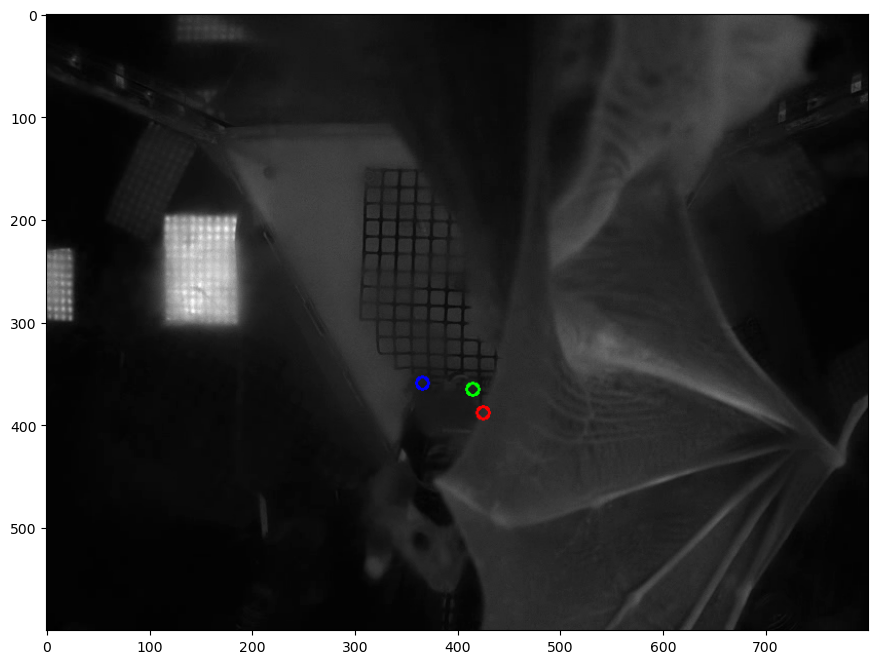

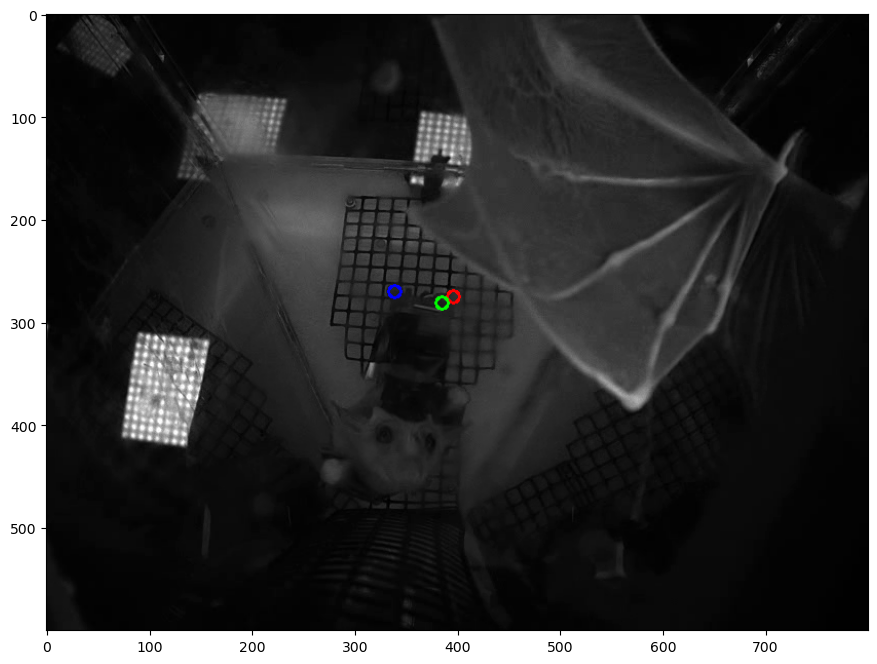

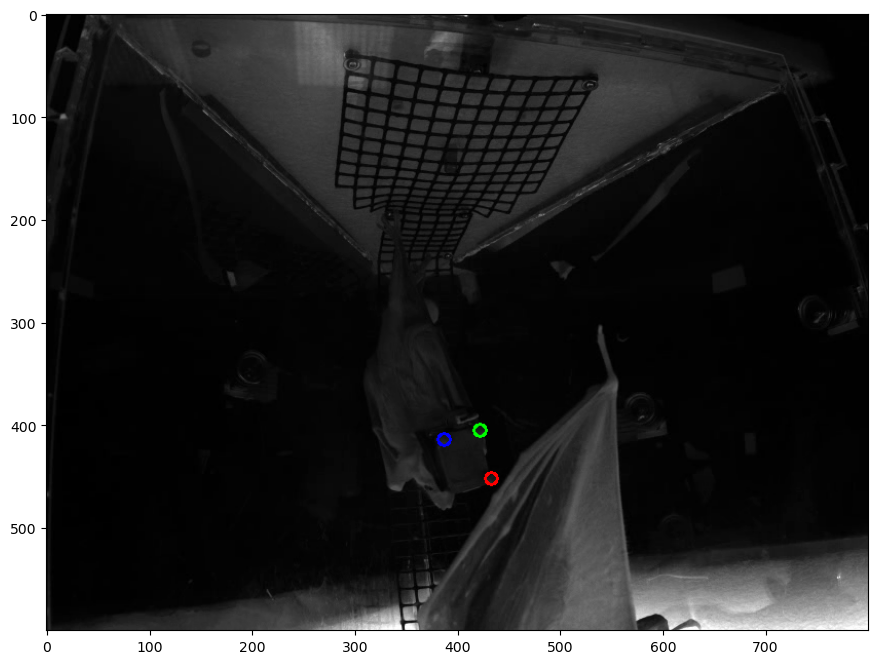

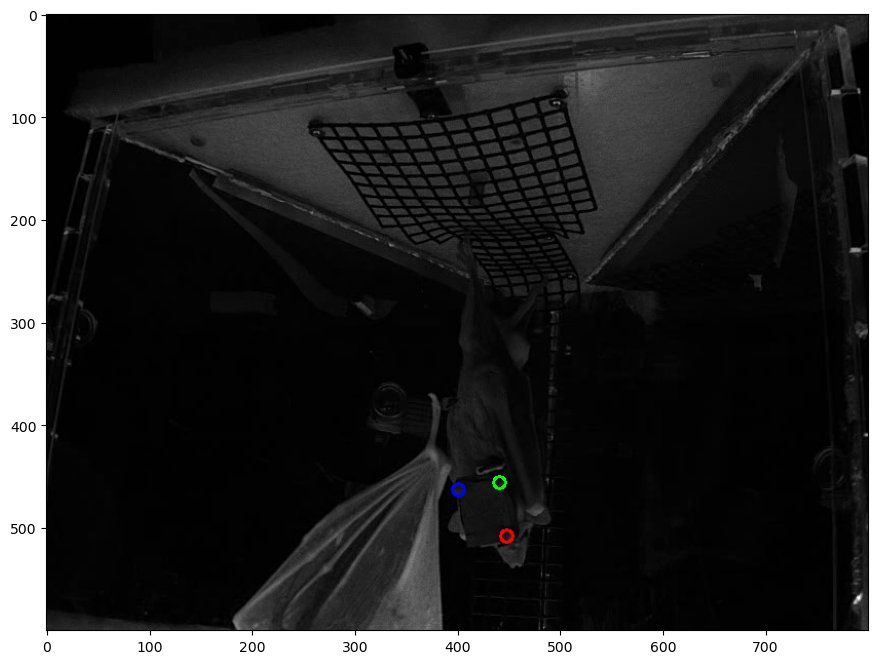

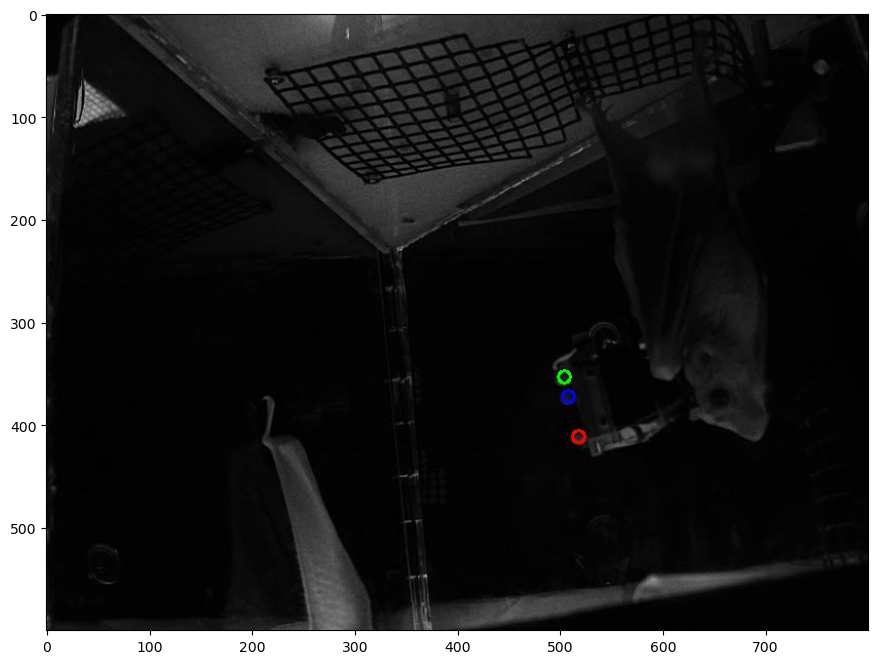

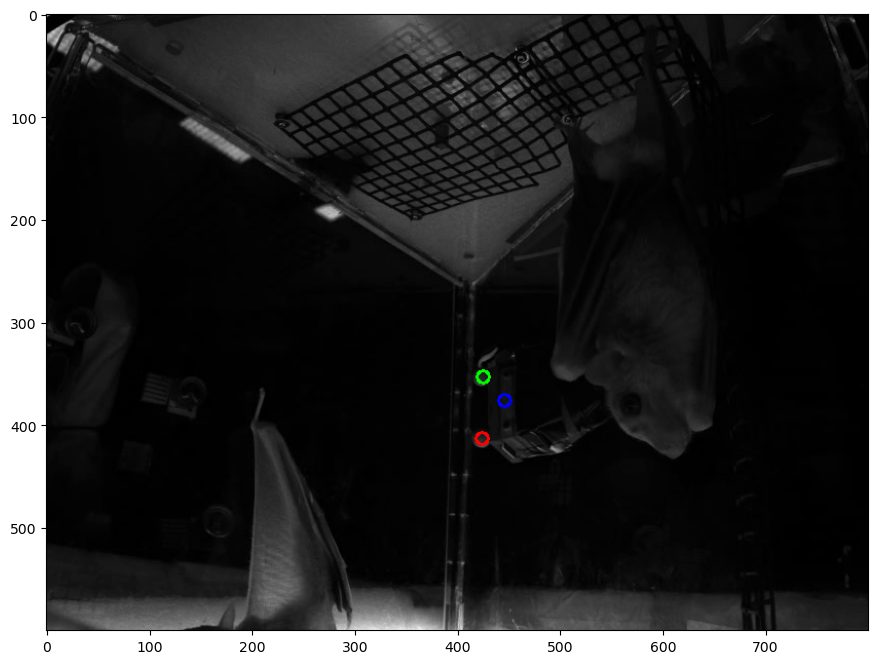

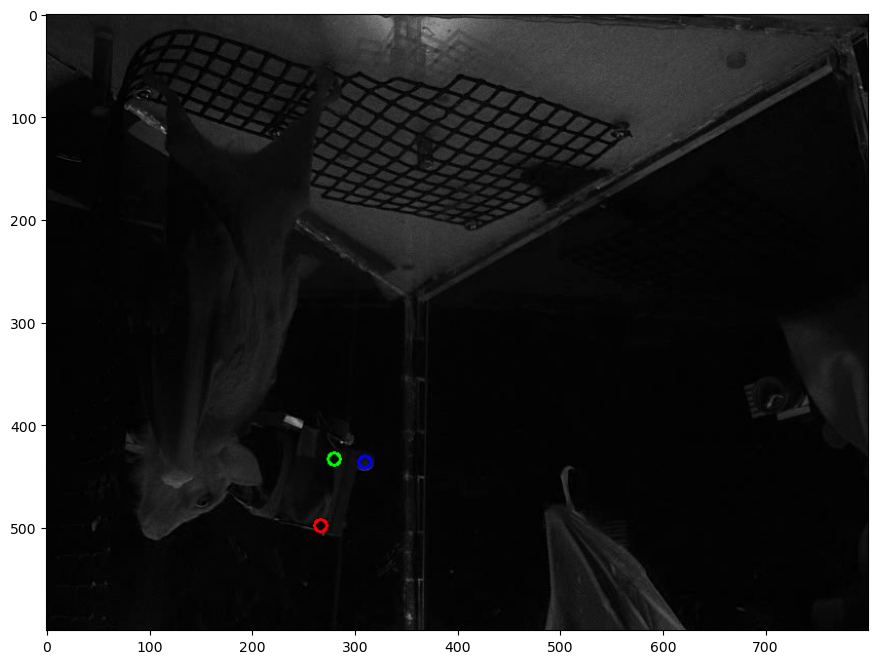

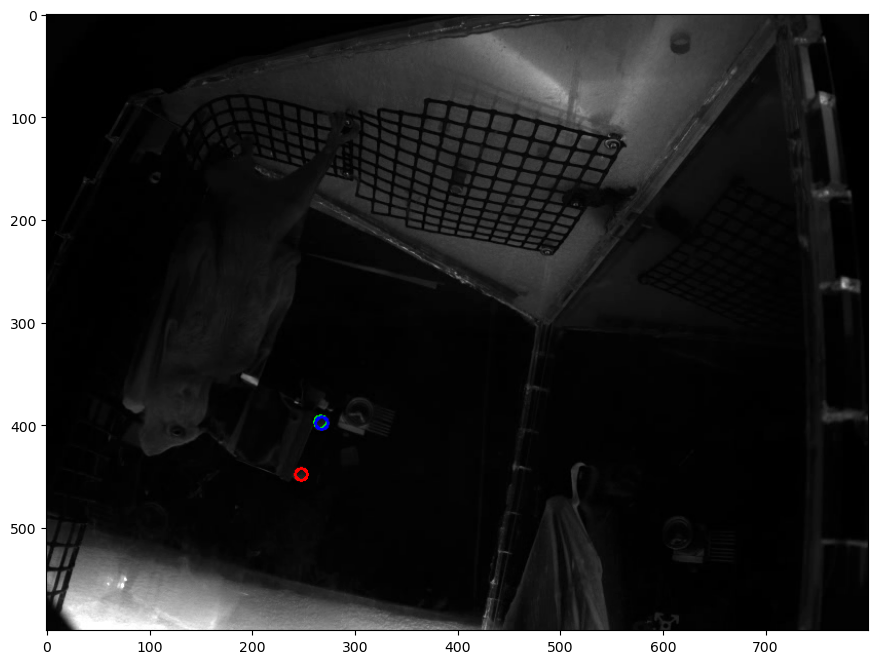

In [19]:
colors = [[255,0,0],[0,255,0],[0,0,255],[255,255,0]]
fnum = 190400
#print(loss[fnum])
#print(reprojerr_debug[fnum])
for i_view in range(len(VIEWS)):
    view = VIEWS[i_view]
    frame = vrs[view][fnum].asnumpy()
    #p2d = c2d_debug[:,fnum,:,:]

    p2d = poss_c2d[:, fnum]
    p2d = cgroup.project(c3d_ransac[fnum,:])
    for j in range(p2d[i_view].shape[0]):
        pt = p2d[i_view][j,:]
        cv2.circle(frame, np.round(pt).astype(np.int16),6, colors[j],2)
    plt.imshow(frame)
    plt.show()

median: 0.09925809490304836 
99th percentile: 0.41365088955723733
% of good frames: 0.990055528911895


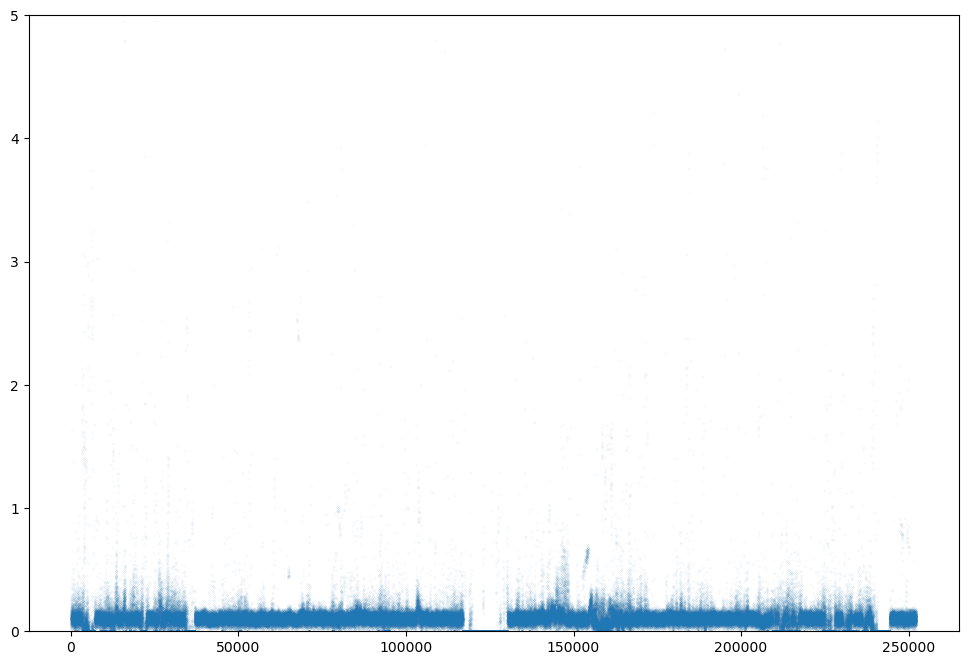

In [20]:
percentile99 = np.nanpercentile(np.nanmedian(ransac_triangulation_errors,1),99.7)
print('median:',np.nanmedian(np.nanmean(ransac_triangulation_errors,1)), '\n99th percentile:', percentile99)
plt.scatter(np.arange(len(np.nanmean(ransac_triangulation_errors,1))), np.nanmean(ransac_triangulation_errors,1), s=0.001)
plt.ylim([0,5])
num_frames_with_detections = np.sum(np.any(ransac_triangulation_errors > 0,1))
num_frames = len(ransac_triangulation_errors)
num_frames_with_good_triangulation = np.sum(np.sum(ransac_triangulation_errors < 1, 1) >= 3)
print('% of good frames:', num_frames_with_good_triangulation/n_frames)

# Save C3D Data

In [52]:
np.save(f'{data_path}/{date}_raw_c2d.npy',poss_c2d)
np.save(f'{data_path}/{date}_ransac_c2d.npy',c2d_ransac)
np.save(f'{data_path}/{date}_ransac_c3d.npy',c3d_ransac)
np.save(f'{data_path}/{date}_ransac_triangulation_errors.npy',ransac_triangulation_errors)
np.save(f'{data_path}/{date}_implant_c3d.npy',implant_c3d)
np.save(f'{data_path}/{date}_correspondence_rmse.npy',correspondence_rmse)

In [11]:
poss_c2d = np.load(f'{data_path}/{date}_raw_c2d.npy')
c2d_ransac = np.load(f'{data_path}/{date}_ransac_c2d.npy')
c3d_ransac = np.load(f'{data_path}/{date}_ransac_c3d.npy')
ransac_triangulation_errors = np.load(f'{data_path}/{date}_ransac_triangulation_errors.npy')

In [23]:
def compute_putative_correspondence(p3d, implant_p3d):
    implant_cdist = scipy.spatial.distance.cdist(implant_p3d, implant_p3d)
    n_points = implant_cdist.shape[0]

    edge_loss = []
    possible_orders = list(itertools.permutations(np.arange(n_points)))
    for x in possible_orders:
        dist = scipy.spatial.distance.cdist(p3d[x,:],p3d[x,:])
        edge_loss.append(np.nanmean(np.square(dist - implant_cdist)))
    best_idx = np.nanargmin(edge_loss)
    best_order = possible_orders[best_idx]

    putative_correspondence = np.vstack([best_order,np.arange(n_points)]).T
    #putative_correspondence=o3d.utility.Vector2iVector(putative_correspondence)
    return putative_correspondence

In [35]:
n_points = 3
implant_c3d = np.full([n_frames,n_points,3], np.nan)
correspondence_rmse = np.full(n_frames, np.nan)
num_dets = n_points - np.sum(np.isnan(c3d_ransac[:,:,0]),1)
for fnum in tqdm(range(n_frames)):
    if(num_dets[fnum] >= 3):
        p3d = c3d_ransac[fnum]
        correspondence = compute_putative_correspondence(p3d, implant_p3d)
        p3d_ord = p3d[correspondence[:,0]]
        implant_c3d[fnum,:,:]=p3d_ord
        cdist_p3d = scipy.spatial.distance.cdist(p3d_ord, p3d_ord)
        cdist_template = scipy.spatial.distance.cdist(implant_p3d, implant_p3d)
        correspondence_rmse[fnum] = np.sqrt(np.sum(np.square(cdist_p3d - cdist_template))/2)
        
implant_c3d[correspondence_rmse>0.003,:,:] = np.nan

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 252301/252301 [00:21<00:00, 11822.53it/s]


In [4]:
plt.plot(correspondence_rmse)

NameError: name 'plt' is not defined

In [47]:
np.where(correspondence_rmse<0.003)

(array([     0,      1,      2, ..., 252297, 252298, 252299]),)

In [ ]:
fnum = 11651
colors = [[255,0,0],[0,255,0],[0,0,255],[255,255,0]]
#print(loss[fnum])
#print(reprojerr_debug[fnum])
for i_view in range(len(VIEWS)):
    view = VIEWS[i_view]
    frame = vrs[view][fnum].asnumpy()
    #p2d = c2d_debug[:,fnum,:,:]

    p2d = poss_c2d[:, fnum]
    p2d = cgroup.project(implant_c3d[fnum,:])
    for j in range(p2d[i_view].shape[0]):
        pt = p2d[i_view][j,:]
        cv2.circle(frame, np.round(pt).astype(np.int16),6, colors[j],2)
    plt.imshow(frame)
    plt.show()

# HD Calculation

In [12]:
implant_c3d = np.load(f'{data_path}/{date}_implant_c3d.npy')

In [13]:
implant_c3d[0,:].shape

(3, 3)

In [14]:
VIEWS

['bottom1',
 'bottom2',
 'front1',
 'front2',
 'right1',
 'right2',
 'left1',
 'left2']

In [15]:
mic_p2d = np.full([8,4,2], np.nan)
mic_p2d[0,:,:] = np.array([[218,151],[596,168],[400,263],[393,488]])
mic_p2d[2,:,:] = np.array([[152,38],[643,83],[394,152],[358,282]])

In [16]:
mic_p3d = cgroup.triangulate(mic_p2d)
mic_err = cgroup.reprojection_error(mic_p3d, mic_p2d, mean=True)
mic_err

array([0.34909358, 0.23958718, 0.40340414, 0.42786018])

In [17]:
mic_p3d

array([[-0.13113065, -0.16846613,  0.39680583],
       [ 0.13594845, -0.15562246,  0.39577366],
       [-0.00183043, -0.0863253 ,  0.40507167],
       [-0.00682188,  0.07043069,  0.42295774]])

In [18]:
X_axis = np.array([1, 0, 0])
Y_axis = np.array([0, 1, 0])
Z_axis = np.array([0, 0, 1])

In [19]:
rt_p3d = implant_c3d[0,:]

ap_axis = rt_p3d[0,:] - rt_p3d[1,:]
ap_axis = ap_axis / np.linalg.norm(ap_axis)
ml_axis = rt_p3d[2,:] - rt_p3d[1,:]
ml_axis = ml_axis / np.linalg.norm(ml_axis)
dv_axis = np.cross(ap_axis, ml_axis)
dv_axis = dv_axis / np.linalg.norm(dv_axis)

In [31]:
import vg

def local_intrinsic_euler(rt_p3d, X_axis, Y_axis, Z_axis):
    #dv_axis = rt_p3d[0,:] - rt_p3d[1,:] # Pointing top of head to bottom of head
    #dv_axis = dv_axis / np.linalg.norm(dv_axis)
    ap_axis = rt_p3d[0,:] - rt_p3d[1,:]
    ap_axis = ap_axis / np.linalg.norm(ap_axis)
    ml_axis = rt_p3d[2,:] - rt_p3d[1,:]
    ml_axis = ml_axis / np.linalg.norm(ml_axis)
    dv_axis = np.cross(ap_axis, ml_axis)

    yaw = vg.signed_angle(Y_axis,ap_axis,Z_axis)
    Y_rot = vg.rotate(Y_axis, Z_axis, yaw)
    X_rot = vg.rotate(X_axis, Z_axis, yaw)
    pitch = vg.signed_angle(Y_rot, ap_axis, X_rot)

    Y_rot = vg.rotate(Y_rot, X_rot, pitch)
    Z_rot = vg.rotate(Z_axis, X_rot, pitch)

    roll = vg.signed_angle(Z_rot, dv_axis, ap_axis)
    X_rot = vg.rotate(X_rot, ap_axis, roll)
    Z_rot = vg.rotate(Z_rot, ap_axis, roll)
    
    return roll, pitch, yaw

def toroidal_euler(rt_p3d, X_axis, Y_axis, Z_axis):
    #dv_axis = rt_p3d[0,:] - rt_p3d[1,:] # Pointing top of head to bottom of head
    #dv_axis = dv_axis / np.linalg.norm(dv_axis)
    ap_axis = rt_p3d[0,:] - rt_p3d[1,:]
    ap_axis = ap_axis / np.linalg.norm(ap_axis)
    ml_axis = rt_p3d[2,:] - rt_p3d[1,:]
    ml_axis = ml_axis / np.linalg.norm(ml_axis)
    dv_axis = np.cross(ap_axis, ml_axis)

    yaw = vg.signed_angle(Y_axis,ml_axis,Z_axis)
    Y_rot = vg.rotate(Y_axis, Z_axis, yaw)
    X_rot = vg.rotate(X_axis, Z_axis, yaw)
    print(X_rot, ap_axis)
    
    pitch = vg.signed_angle(X_rot, ap_axis, Y_rot)

    #Y_rot = vg.rotate(Y_rot, X_rot, pitch)
    X_rot = vg.rotate(X_rot, Y_rot, pitch)
    Z_rot = vg.rotate(Z_axis, Y_rot, pitch)

    roll = vg.signed_angle(Z_rot, dv_axis, X_rot)
    X_rot = vg.rotate(X_rot, ap_axis, roll)
    Z_rot = vg.rotate(Z_rot, ap_axis, roll)
    
    
    return roll, pitch, np.mod(yaw+180+90,360)-180

    

In [22]:
implant_roll = np.full(n_frames, np.nan)
implant_pitch = np.full(n_frames, np.nan)
implant_yaw = np.full(n_frames, np.nan)

for fnum in tqdm(range(n_frames)):
    roll, pitch, yaw = toroidal_euler(implant_c3d[fnum,:,:], X_axis, Y_axis, Z_axis)
    implant_roll[fnum] = roll
    implant_pitch[fnum] = pitch
    implant_yaw[fnum] = yaw

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 252301/252301 [01:10<00:00, 3594.94it/s]


In [32]:
toroidal_euler(implant_c3d[0,:], X_axis, Y_axis, Z_axis)

[ 0.57627875 -0.8172532   0.        ] [ 0.38233151 -0.7811563  -0.49357619]


(-11.13129916185724, 29.889136974735457, 35.18923325251586)

120.96525743281097
-8.190337008145297


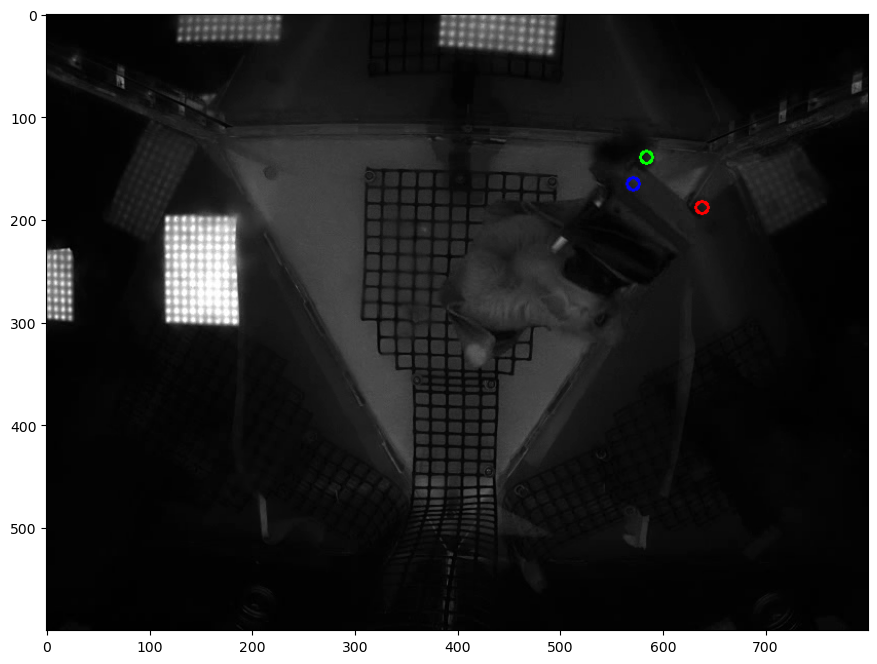

In [57]:
fnum = 1000
colors = [[255,0,0],[0,255,0],[0,0,255],[255,255,0]]
print(implant_yaw[fnum])
print(implant_pitch[fnum])
#print(reprojerr_debug[fnum])
for i_view in range(len(VIEWS)):
    view = VIEWS[i_view]
    frame = vrs[view][fnum].asnumpy()
    #p2d = c2d_debug[:,fnum,:,:]

    p2d = poss_c2d[:, fnum]
    p2d = cgroup.project(implant_c3d[fnum,:])
    for j in range(p2d[i_view].shape[0]):
        pt = p2d[i_view][j,:]
        cv2.circle(frame, np.round(pt).astype(np.int16),6, colors[j],2)
    plt.imshow(frame)
    plt.show()
    break

In [68]:
implant_hd = {}
implant_hd['roll'] = implant_roll
implant_hd['pitch'] = implant_pitch
implant_hd['yaw'] = implant_yaw
#np.save(f'{data_path}/{date}_implant_head_direction_toroidal.npy',implant_hd)

# Rigid Body Fit

In [24]:
import scipy.spatial.transform as transform
from scipy.optimize import least_squares

import open3d as o3d
import open3d.utility
import copy
import numpy as np

def fun(x, cgroup, rb, p2d):
    """
    x : rigid body params
    """
    
    rot_vec = x[:4]
    t_vec = x[4:]
    
    R = transform.Rotation.from_quat(rot_vec)
    
    r_p3d = R.apply(rb)
    rt_p3d = r_p3d + t_vec
    
    rt_proj = cgroup.project(rt_p3d)
    
    err = np.full(rt_proj.shape[0],np.nan)
    for i in range(rt_proj.shape[0]): # For each view, find closest point in detections
        #print(p2d[i,:,:])
        #print(rt_proj[i,:,:])

        is_not_nan = np.all(~np.isnan(p2d[i,:,:]),1) # nan mask.

        # p2d to rt_proj distances
        dist = scipy.spatial.distance.cdist(p2d[i,:,:], rt_proj[i,:,:])
        dist[np.where(np.isnan(dist))] = 999

        # Linear sum assignment problem
        rb_idx, p2d_idx = scipy.optimize.linear_sum_assignment(dist)
        err[i] = np.nansum(dist[rb_idx, p2d_idx][is_not_nan])
                
    #proj_err = np.nanmean(cgroup.reprojection_error(rt_p3d, p2d, mean=True))
    return np.sqrt(np.nanmean(np.square(err)))

def fun_old(x, cgroup, rb, p2d):
    """
    x : rigid body params
    """
    
    rot_vec = x[:4]
    t_vec = x[4:]
    
    R = transform.Rotation.from_quat(rot_vec)
    
    r_p3d = R.apply(rb)
    rt_p3d = r_p3d + t_vec
    
    rt_proj = cgroup.project(rt_p3d)
    
    err = []
    for i in range(rt_proj.shape[0]): # For each view, find closest point in detections
        #print(p2d[i,:,:])
        #print(rt_proj[i,:,:])

        is_not_nan = np.all(~np.isnan(p2d[i,:,:]),1) # nan mask.

        # p2d to rt_proj distances
        dist = scipy.spatial.distance.cdist(p2d[i,:,:], rt_proj[i,:,:])
    
        # Check every permutation for best pairwise matching based on closest distance
        idx = np.arange(4)[is_not_nan]
        permutations = list(itertools.permutations(np.arange(4),r = int(np.sum(is_not_nan))))
        costs = [np.nansum(dist[idx,perm]) for perm in permutations]
        best_perm = np.nanargmin(costs)
        
        err += [costs[best_perm]**2]
        
    #proj_err = np.nanmean(cgroup.reprojection_error(rt_p3d, p2d, mean=True))
    return np.sqrt(np.nanmean(err))

def numpy2pcd(p3d_numpy):
    p3d_pcd = o3d.geometry.PointCloud()
    p3d_pcd.points = o3d.utility.Vector3dVector(p3d_numpy)
    return p3d_pcd

def draw_registration_result(source, target, transformation):
    """
    Plot registration results.

    Parameters
    ----------
    source, target : np.array() or open3d.geometry.PointCloud()

    transformation : np.array(3,4)
        Transformation from registration results

    """

    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    if(not isinstance(source_temp, o3d.geometry.PointCloud)):
        source_temp = numpy2pcd(source_temp)
    if(not isinstance(target_temp, o3d.geometry.PointCloud)):
        target_temp = numpy2pcd(target_temp)
    source_temp.paint_uniform_color([0, 0, 1])
    target_temp.paint_uniform_color([1, 0, 0])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])


def compute_surface_normals(pcd, voxel_size):
    #print(":: Downsample with a voxel size %.3f." % voxel_size)
    #pcd_down = o3d.geometry.voxel_down_sample(pcd, voxel_size)

    radius_normal = voxel_size * 2
    #print(":: Estimate normal with search radius %.3f." % radius_normal)
    o3d.geometry.PointCloud.estimate_normals(
        pcd,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 10
    #print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_fpfh

"""
def execute_global_registration(source, target, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = 0.01
    #print(":: RANSAC registration on downsampled point clouds.")
    #print("   Since the downsampling voxel size is %.3f," % voxel_size)
    #print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source,
        target,
        source_fpfh,
        target_fpfh,
        True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3,
        [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)
        ],
        o3d.pipelines.registration.RANSACConvergenceCriteria(500000, 5000))
    return result"""

def compute_putative_correspondence(p3d, implant_p3d):
    implant_cdist = scipy.spatial.distance.cdist(implant_p3d, implant_p3d)
    n_points = implant_cdist.shape[0]

    edge_loss = []
    possible_orders = list(itertools.permutations(np.arange(n_points)))
    for x in possible_orders:
        dist = scipy.spatial.distance.cdist(p3d[x,:],p3d[x,:])
        edge_loss.append(np.nanmean(np.square(dist - implant_cdist)))
    best_idx = np.nanargmin(edge_loss)
    best_order = possible_orders[best_idx]

    putative_correspondence = np.vstack([best_order,np.arange(n_points)]).T
    putative_correspondence=o3d.utility.Vector2iVector(putative_correspondence)
    return putative_correspondence

def execute_correspondence_registration(source, target, putative_correspondence):
    distance_threshold = 0.5
    #print(":: RANSAC registration on downsampled point clouds.")
    #print("   Since the downsampling voxel size is %.3f," % voxel_size)
    #print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_correspondence(
        source,
        target,
        putative_correspondence,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3,
        [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)
        ],
        o3d.pipelines.registration.RANSACConvergenceCriteria(1000, 50))
    return result

def execute_global_registration(source, target, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = 0.5
    #print(":: RANSAC registration on downsampled point clouds.")
    #print("   Since the downsampling voxel size is %.3f," % voxel_size)
    #print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source,
        target,
        source_fpfh,
        target_fpfh,
        False,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3,
        [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)
        ],
        o3d.pipelines.registration.RANSACConvergenceCriteria(1000, 50))
    return result

def local_registration_icp(source, target, threshold, init_transform):
    #print("Apply point-to-point ICP")
    result = o3d.pipelines.registration.registration_icp(
        source, target, threshold, init_transform,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1.000000e-8,
                                                                        relative_rmse=1.000000e-8,
                                                                        max_iteration=2000))
    #print(reg_p2p)
    #print("Transformation is:")
    #print(reg_p2p.transformation)
    return result

def point_cloud_registration(source, target, putative_correspondence):
    """
    Point cloud registration via rigid body transforms

    Parameters
    ----------
    source, target | open3d.geometry.PointCloud

    Returns
    -------
    Registration results
    """
    voxel_size = 0.5
    source_fpfh = compute_surface_normals(source, voxel_size)
    target_fpfh = compute_surface_normals(target, voxel_size)

    # Rough global registration
    #global_result = execute_global_registration(source, target, source_fpfh, target_fpfh, voxel_size)
    global_result_via_correspondence = execute_correspondence_registration(source, target, putative_correspondence)
    global_result_via_features = execute_global_registration(source, target, source_fpfh, target_fpfh, voxel_size)
    
    #print('features rmse', global_result_via_features.inlier_rmse)
    #print('correspondence rmse', global_result_via_correspondence.inlier_rmse)
    
    # Fine local (ICP) registration initialized by global registration
    if(global_result_via_features.inlier_rmse < global_result_via_correspondence.inlier_rmse):
        transformation = global_result_via_features.transformation
    else:
        transformation = global_result_via_correspondence.transformation

    local_result = local_registration_icp(source, target, voxel_size*2, transformation)


    return local_result, global_result_via_features, global_result_via_correspondence

def compute_rigid_body_registration(p3d, model_p3d):
    """
    Compute point - point correspondence via rigid body transformations
    using point cloud registration methods

    Assumes points belong to some rigidbody.

    Parameters
    ----------
    p3d : np.array(N_points, 3)
        Detected marker positions

    model_p3d : np.array(N_points, 3)
        Known positions of markers on rigidbody.

    Returns
    -------
    ordered_p3d : np.array(N_points, 3)
        Detected marker positions ordered by correspondence to model marker positions
    correspondence_set : np.array(N_points, 2)
        Correspondences between p3d and model_p3d
    transform : np.array(3,4)
        Rigidbody transform from model_p3d to p3d
    rmse : float
        Root mean square error of registration. High values likely mean registration has failed.
    """

    putative_correspondence = compute_putative_correspondence(p3d, model_p3d)

    # Convert numpy to PointCloud
    target = numpy2pcd(model_p3d)
    source = numpy2pcd(p3d)

    # Compute point cloud registration
    res, res_global_via_feats, res_global_via_corres = point_cloud_registration(source, target, putative_correspondence)

    correspondence_set = np.asarray(res.correspondence_set)

    ordered_p3d = np.full(p3d.shape, np.nan)
    for i in range(correspondence_set.shape[0]):
        mapping = correspondence_set[i]
        ordered_p3d[mapping[0]] = p3d[mapping[1]]

    transformation = res.transformation

    rmse = res.inlier_rmse

    return ordered_p3d, correspondence_set, transformation, rmse

def rigid_body_pose_estimation_ransac(triangulated_p3d, implant_p3d, p2d):
    bounds=[(-1,1),(-1,1),(-1,1),(-1,1),(-0.5,0.5),(-0.5,0.5),(-0.5,0.5)]

    best_err = np.inf
    best_x0 = np.zeros([7,])
    best_pcr_transform = np.zeros([4,4])

    p3d = triangulated_p3d.copy()

    # Compute transformation from triangulated markers to implant T-pose
    # For whatever reason, the other direction doesn't work well...
    ordered_p3d, pcd_correspondence, transformation, rmse = compute_rigid_body_registration(p3d, implant_p3d)

    # Invert the transformation to transform T-pose to triangulated marker position
    R0 = transformation[:3,:3].T.copy() # Inverse rotation
    t0 = -np.matmul(R0, transformation[:3,-1]) # Inverse translation

    R0 = transform.Rotation.from_matrix(R0)

    # initialize x0 guess
    x0 = np.zeros([7,])
    #x0[:4] = np.array([0,0,0,1])
    x0[:4] = R0.as_quat()
    x0[4:] = t0

    err = fun(x0, cgroup,implant_p3d, p2d)
    if(err < best_err):
        best_err = err
        best_x0 = x0
        best_pcr_transform = transformation
    
    
    #print(fun(best_x0, cgroup, implant_p3d, p2d))
    res = scipy.optimize.minimize(fun, 
                                  best_x0, 
                                  method='SLSQP', 
                                  args=(cgroup, implant_p3d, p2d), 
                                  bounds=bounds,
                                  options={
                                      'disp': False
                                  })
    #print(res)

    return res, best_pcr_transform

ModuleNotFoundError: No module named 'open3d.utility'

In [20]:
n_points = c2d_ransac.shape[2]

In [21]:
implant_c3d = np.full([n_frames,n_points,3], np.nan)
pcr_rmse = np.full(n_frames, np.nan)
num_dets = n_points - np.sum(np.isnan(c3d_ransac[:,:,0]),1)
for fnum in tqdm(range(n_frames)):
    if(num_dets[fnum] >= 3):
        res, _ = rigid_body_pose_estimation_ransac(c3d_ransac[fnum], implant_p3d, poss_c2d[:,fnum])
        pcr_rmse[fnum] = res.fun

        R = transform.Rotation.from_quat(res.x[:4])
        t = res.x[4:]

        implant_c3d[fnum] = R.apply(implant_p3d) + t

  0%|      | 0/252301 [00:00<?, ?it/s]


AttributeError: module 'open3d' has no attribute 'utility'

In [14]:
fnum = 0
triangulated_p3d = c3d_ransac[fnum]
p2d = poss_c2d[:,fnum]
bounds=[(-1,1),(-1,1),(-1,1),(-1,1),(-0.5,0.5),(-0.5,0.5),(-0.5,0.5)]

best_err = np.inf
best_x0 = np.zeros([7,])
best_pcr_transform = np.zeros([4,4])

p3d = triangulated_p3d.copy()

In [ ]:
# Compute transformation from triangulated markers to implant T-pose
# For whatever reason, the other direction doesn't work well...
ordered_p3d, pcd_correspondence, transformation, rmse = compute_rigid_body_registration(p3d, implant_p3d)

In [22]:
putative_correspondence = compute_putative_correspondence(p3d, implant_p3d)
np.asarray(putative_correspondence)

array([[2, 0],
       [1, 1],
       [0, 2]], dtype=int32)

In [ ]:
voxel_size = 0.5
    source_fpfh = compute_surface_normals(source, voxel_size)
    target_fpfh = compute_surface_normals(target, voxel_size)

    # Rough global registration
    #global_result = execute_global_registration(source, target, source_fpfh, target_fpfh, voxel_size)
    global_result_via_correspondence = execute_correspondence_registration(source, target, putative_correspondence)
    global_result_via_features = execute_global_registration(source, target, source_fpfh, target_fpfh, voxel_size)

In [ ]:
# Convert numpy to PointCloud
target = numpy2pcd(implant_p3d)
source = numpy2pcd(p3d)

# Compute point cloud registration
res, res_global_via_feats, res_global_via_corres = point_cloud_registration(source, target, putative_correspondence)


In [17]:
implant_c3d = np.full([n_frames,n_points,3], np.nan)
pcr_rmse = np.full(n_frames, np.nan)
num_dets = n_points - np.sum(np.isnan(c3d_ransac[:,:,0]),1)

In [18]:
rigid_body_pose_estimation_ransac(c3d_ransac[fnum], implant_p3d, poss_c2d[:,fnum])

3

In [73]:
np.nanmedian(pcr_rmse)

0.954623115611688

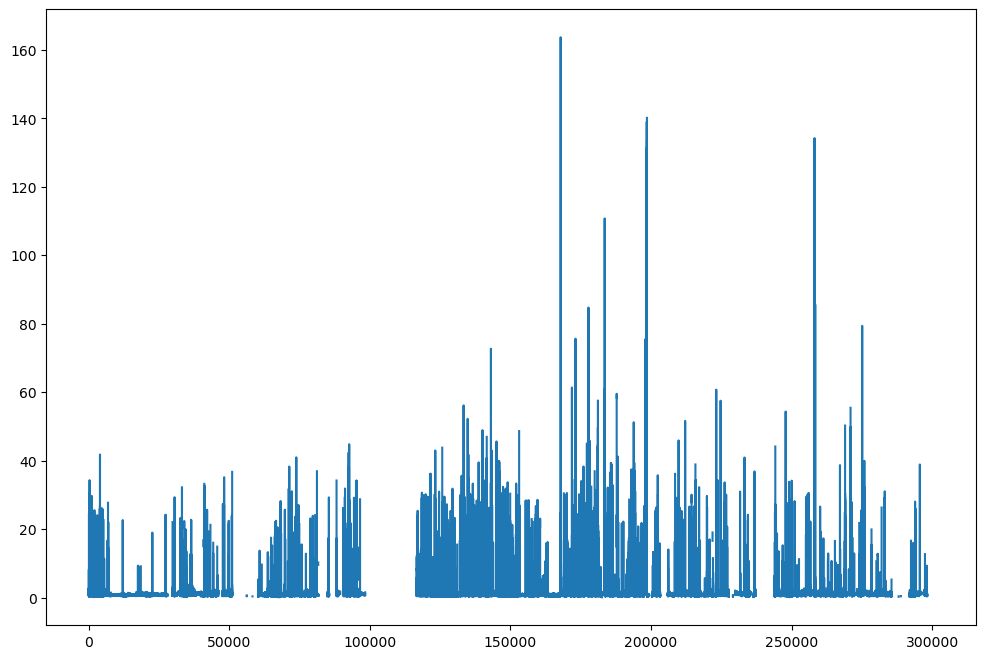

In [74]:
plt.plot(pcr_rmse)

In [84]:
np.sum(pcr_rmse<10)/len(pcr_rmse)

0.4520026481297584

263
0.0002376884524559104 [0.0010842  0.04073588 0.5608634 ] 0.7275990684581017


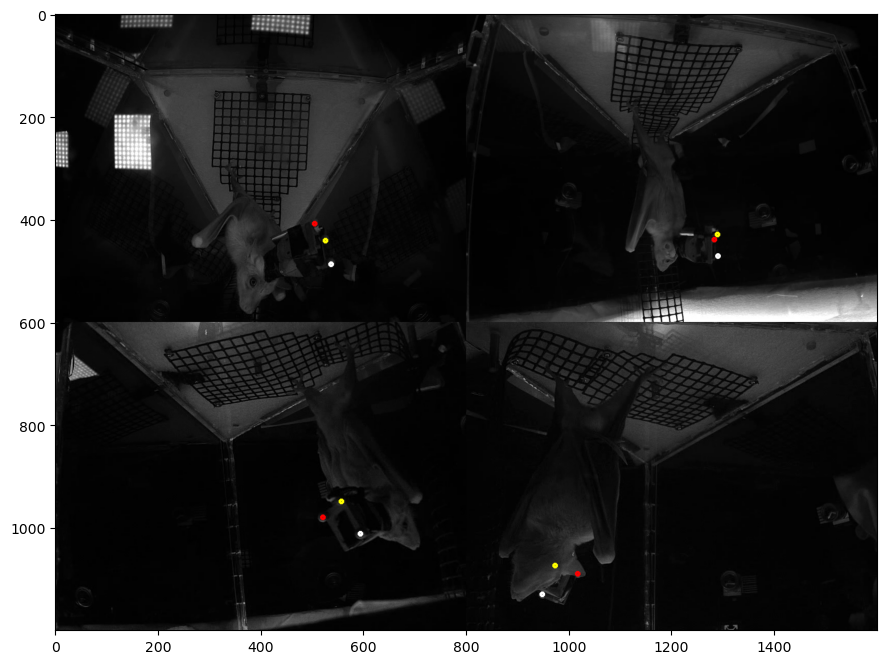

In [58]:
fnum = 27*10*5+900
fnum = 10*15*5+35
#fnum = 3994
fnum = 263
#fnum = 2613*25*2
w = 800
h = 600
print(fnum)
p3ds = implant_c3d[fnum]
#p3ds = c3d_ransac[fnum]
print(template_errors[fnum], ransac_triangulation_errors[fnum], pcr_rmse[fnum])
is_valid_frame = np.any(~np.isnan(p3ds))

if(is_valid_frame):
    #R_operator = transform.Rotation.from_euler('xyz', R, degrees=True)

    #rt_p3d = R_operator.apply(implant_p3d) + T
    rt_p3d = p3ds
    rt_p2d = cgroup.project(rt_p3d)



frames = []
grid_idx = [[0,0],[0,1],[1,0],[1,1]]

for j in range(0,len(VIEWS),2):
    view = VIEWS[j]
    frame = vrs[view][fnum].asnumpy()
    if(is_valid_frame):
        marker_coords = rt_p2d[j,:]
        marker_coords = np.round(marker_coords).astype(np.int32)

        edges_idx = [0,1,3,1,2]
        colors = [[255,255,255],[255,255,0],[255,0,0],[0,0,255]]
        for i in range(marker_coords.shape[0]):
            coord = marker_coords[i]
            cv2.circle(frame, coord, 3, colors[i], 3)

        #cv2.polylines(frame, [marker_coords[edges_idx]], False, (255,255,255), 2, lineType=cv2.LINE_AA)
    frames.append(frame)

img = np.hstack(frames)
img = np.vstack([img[:,:2*w,:],img[:,2*w:,:]])
plt.imshow(img)

# Interpolation

In [59]:
from hampel import hampel
def hampel_outliers(implant_c3d):
    is_outlier = np.full(implant_c3d.shape[0], False)
    for i in range(implant_c3d.shape[1]):
        for j in range(implant_c3d.shape[2]):
            c3d_series = pd.Series(implant_c3d[:,i,j])
            is_outlier[hampel(c3d_series, window_size=3, n=3)] = True
    return is_outlier

def mask_gaps(c3d, min_gap_size):
    """
    min_gap_size: int
        minimum gap size to mask (mask ignores gaps of smaller size)
    """
    df = pd.DataFrame()
    df['x'] = c3d[:,0,0]

    N=min_gap_size
    mask = df['x'].isna()
    min_gap_mask = (
        mask.groupby((mask != mask.shift()).cumsum()).transform(
            lambda x: len(x) > N
        )
        * mask
    )
    
    return min_gap_mask

def interp(c3d, med_filt = True):
    is_nan_idx = np.any(np.any(np.isnan(c3d),2),1)


    sample_idx = np.arange(c3d.shape[0])
    measured_sample_idx = sample_idx[~is_nan_idx]
    
    
    samples = c3d[~is_nan_idx]
        
    interp_c3d = np.full(c3d.shape, np.nan)
    for i in range(c3d.shape[1]):
        for j in range(c3d.shape[2]):
            interpolater = scipy.interpolate.interp1d(measured_sample_idx, samples[:,i,j],'cubic', bounds_error=False)
            interp_c3d[:,i,j] = scipy.signal.medfilt(interpolater(sample_idx), 3)
        
    return interp_c3d

In [60]:
threshold = 35
is_hampel_outlier = hampel_outliers(implant_c3d) # Detect large deviations from windowed median
print("Number of hampel outliers:", np.sum(is_hampel_outlier))
is_outlier = np.logical_and(is_hampel_outlier, pcr_rmse > 5) # True outliers should have large pcr_rmse as well
print("Number of outliers exceeding 5 rmse", np.sum(pcr_rmse > 5))
is_outlier = np.logical_or(is_outlier, pcr_rmse>35) # Very large pcr_rmse must be outliers
print("Number of outliers exceeding 35 rmse", np.sum(pcr_rmse > 35))

print("Number of true outliers", np.sum(is_outlier)) # Final number of outliers

Number of hampel outliers: 38839
Number of outliers exceeding 5 rmse 3524
Number of outliers exceeding 35 rmse 163
Number of true outliers 1957


In [61]:
good_implant_c3d = implant_c3d.copy()
good_implant_c3d[is_outlier,:,:] = np.nan

In [68]:
nan_gap_mask = mask_gaps(good_implant_c3d, 5)
print("Number of unfillable nans", np.sum(nan_gap_mask))
np.where(nan_gap_mask)

Number of unfillable nans 141006


(array([    25,     26,     27, ..., 302097, 302098, 302099]),)

In [72]:
implant_c3d[25,:,:]

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

In [63]:
good_filled_implant_c3d = interp(good_implant_c3d)
good_filled_implant_c3d[nan_gap_mask] = np.nan

Text(0.5, 1.0, 'Cleaned ir marker trajectories')

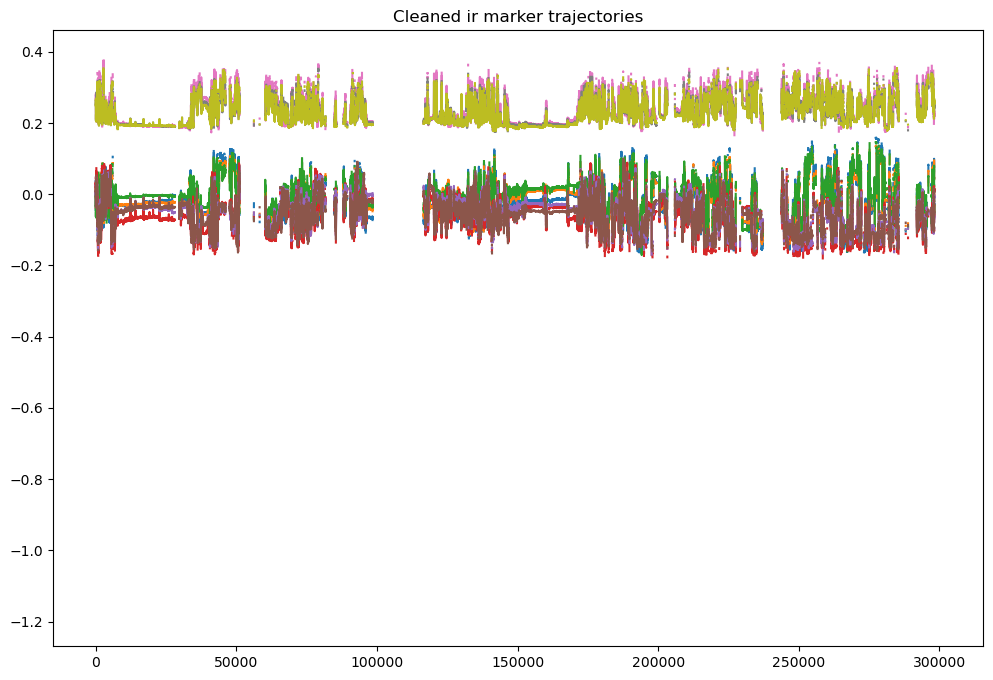

In [64]:
for i in range(3):
    plt.plot(good_filled_implant_c3d[:,:,i])
plt.title("Cleaned ir marker trajectories")

In [86]:
print(f'{100*(1-np.sum(np.isnan(good_filled_implant_c3d[:,0,0]))/n_frames)}% frames are good')

53.32472691161867% frames are good


In [87]:
good_filled_implant_c3d.shape

(302100, 3, 3)

# Save Data

In [88]:
poss_c2d.shape

(8, 302100, 3, 2)

In [89]:
implant_tracking = {}
implant_tracking['c3d_ransac'] = c3d_ransac
implant_tracking['c2d_ransac'] = c2d_ransac
implant_tracking['c2d'] = poss_c2d
implant_tracking['implant_c3d'] = implant_c3d
implant_tracking['filtered_implant_c3d'] = good_filled_implant_c3d
implant_tracking['template_errors'] = template_errors
implant_tracking['ransac_triangulation_errors'] = ransac_triangulation_errors
implant_tracking['rigid_body_registration_errors'] = pcr_rmse

In [90]:
np.save(f'{data_path}/{bat_id}_{date}_implant_tracking.npy',implant_tracking)

In [91]:
np.save(f'{data_path}/{bat_id}_{date}_good_filled_implant_c3d.npy',good_filled_implant_c3d)
np.save(f'{data_path}/{bat_id}_{date}_implant_c3d.npy',implant_c3d)

# Plot video

In [92]:
h = 600
w = 800
hds = 300
wds = 400

fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video_writer=cv2.VideoWriter(f'{data_path}/{bat_id}_{date}_implant_tracking.avi',fourcc,100,(wds,hds))

for fnum in tqdm(range(0,n_frames)):
    #R = rotations_euler[fnum,:]
    #T = filled_translations[fnum,:]
    p3ds = good_filled_implant_c3d[fnum]
    is_valid_frame = np.any(~np.isnan(p3ds))# and pcr_rmse[fnum] < 5
    
    if(is_valid_frame):
        #R_operator = transform.Rotation.from_euler('xyz', R, degrees=True)

        #rt_p3d = R_operator.apply(implant_p3d) + T
        rt_p3d = p3ds
        rt_p2d = cgroup.project(rt_p3d)
    
    frames = []
    grid_idx = [[0,0],[0,1],[1,0],[1,1]]
    
    for j in range(0,len(VIEWS),2):
        view = VIEWS[j]
        frame = vrs[view][fnum].asnumpy()
        if(is_valid_frame):
            marker_coords = rt_p2d[j,:]
            marker_coords = np.round(marker_coords).astype(np.int32)

            edges_idx = [0,1,3,1,2]
            colors = [[255,255,255],[255,255,0],[255,0,0],[0,0,255]]
            for i in range(marker_coords.shape[0]):
                coord = marker_coords[i]
                cv2.circle(frame, coord, 3, colors[i], 3)

            #cv2.polylines(frame, [marker_coords[edges_idx]], False, (255,255,255), 2, lineType=cv2.LINE_AA)
        frames.append(frame)
    
    img = np.hstack(frames)
    img = np.vstack([img[:,:2*w,:],img[:,2*w:,:]])
    img = cv2.resize(img, (wds,hds))
    
    video_writer.write(img)    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 302100/302100 [14:37<00:00, 344.38it/s]
